In [1]:
import pandas as pd
import time

f = open('data.csv', 'r')
raw_data = f.readlines()
clean_data = [line.split(',') for idx, line in enumerate(raw_data) if idx != 0]
clean_data[:5]

[['Call Out',
  'AA2765',
  '20180102 141000',
  '[ECP] 去電確認開戶文件 客戶說後來去買美元保單就不開戶了',
  '\n'],
 ['Call Out', 'AA3910', '20180102 144300', '[ECP]不方說  IPO MAIL', '\n'],
 ['Call Out', 'AA3167', '20180102 154500', '[ECP] IPO 忙 先MAIL', '\n'],
 ['Call Out', 'AA2355', '20180102 194359', '家庭戶 媽媽說女兒不開了，因為打工收入不穩定', '\n'],
 ['Call Out', 'AA2778', '20180103 111132', '推Q1', '\n']]

In [2]:
## First, get how many phonecalls per client
import matplotlib.pyplot as plt
import matplotlib

CallOutList = {}    # dict key:客戶ＩＤ，value:客戶通話次數
for row in clean_data:
    clienID = row[1]
    if clienID not in CallOutList:
        CallOutList[clienID] = 0
    CallOutList[clienID] += 1
CallOutNum = {}    # dict key:通話次數，value:客戶人數
for clienID in CallOutList:
    if CallOutList[clienID] not in CallOutNum:
        CallOutNum[CallOutList[clienID]] = [0, []]
    CallOutNum[CallOutList[clienID]][0] += 1
    CallOutNum[CallOutList[clienID]][1].append(clienID)
    
keys = list(CallOutNum.keys())
values = [CallOutNum[key][0] for key in keys]


zhfont1 =  matplotlib.font_manager.FontProperties(fname='./simfang.ttf')
fig = plt.figure()
plt.xlabel('通話次數', fontproperties=zhfont1)
plt.ylabel('客戶人數', fontproperties=zhfont1)
plt.bar(keys, height=values, bottom=2.0)

# keys, values

<Container object of 9 artists>

可以看到通話一次的客戶是最多的，有350人。所以接下來分成兩個部分去分析：分析只能通話一次兩次的客服紀錄內容、分析通話次數較高的客服內容，藉此優化推銷品質


In [3]:
LessPhoneCall = [1]  #定義比較少打電話的次數是幾次
MorePhoneCall = [2, 3, 4, 5, 6, 7, 8, 14]

LessPhoneCallContent = [row[3] for row in clean_data if CallOutList[row[1]] in LessPhoneCall]   #比較少通話的客戶的通話內容
MorePhoneCallContent = [row[3] for row in clean_data if CallOutList[row[1]] in MorePhoneCall]
LessPhoneCallClient = [client for client in CallOutList if CallOutList[client] in LessPhoneCall] #比較少通話的客戶的客戶ＩＤ
MorePhoneCallClient = [client for client in CallOutList if CallOutList[client] in MorePhoneCall]

LessPhoneCallContent[:5], MorePhoneCallContent[:5], LessPhoneCallClient[:5], MorePhoneCallClient[:5]

(['[ECP] 去電確認開戶文件 客戶說後來去買美元保單就不開戶了',
  '推Q1',
  '"兒子要開戶未成年',
  '林O屏216022 家庭戶 有可能有這戶下單又嫌麻煩',
  '要用女兒名字開'],
 ['[ECP]不方說  IPO MAIL',
  '[ECP] IPO 忙 先MAIL',
  '家庭戶 媽媽說女兒不開了，因為打工收入不穩定',
  '台幣 瑞興 轉介208',
  '想買基金 推EC 轉介之'],
 ['AA3427', 'AA2867', 'AA9929', 'AA3444', 'AA6342'],
 ['AA3363', 'AA3378', 'AA9427', 'AA2956', 'AA7780'])

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/mq/8nbd7rkj7rg8lb_84m9cnvk80000gn/T/jieba.cache
Loading model cost 2.952 seconds.
Prefix dict has been built succesfully.


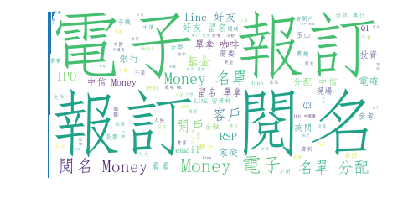

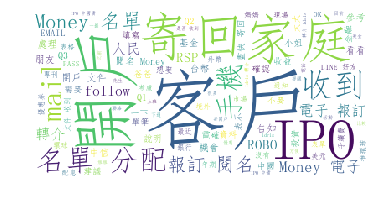

In [4]:
import jieba
from wordcloud import WordCloud

def MakeWordCloud(contents):
    with open('stopwords.txt', 'r') as f:
        stopwords = [line.replace('\n', "") for line in f.readlines()]
    text = []
    for row in contents:
        row = jieba.cut(row)
        for term in row:
            if term not in stopwords:
                text.append(term)
                
    text = ",".join(text)
    
    wc = WordCloud(font_path="./simfang.ttf", #設置字體
               background_color="white",      #背景顏色
               max_words = 100 ,              #文字雲顯示最大詞數
               stopwords=stopwords)           #停用字詞
    wc.generate(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.figure(figsize=(10,10), dpi = 100)
    plt.show()
    
MakeWordCloud(LessPhoneCallContent)
MakeWordCloud(MorePhoneCallContent)

In [5]:
# 做出TDM, 用客戶做區別。
LessClienteachPhoneCall = {}
MoreClienteachPhoneCall = {}

for client in LessPhoneCallClient:
    for row in clean_data:
        if client == row[1]:
            if client not in LessClienteachPhoneCall:
                LessClienteachPhoneCall[client] = []
            LessClienteachPhoneCall[client].append(row[3])
            
for client in MorePhoneCallClient:
    for row in clean_data:
        if client == row[1]:
            if client not in MoreClienteachPhoneCall:
                MoreClienteachPhoneCall[client] = []
            MoreClienteachPhoneCall[client].append(row[3])

LessClienteachPhoneCall[LessPhoneCallClient[0]], MoreClienteachPhoneCall[MorePhoneCallClient[0]]

(['"Money名單'], ['Money名單分配 中信', '[ECP]ec追蹤 會回台中家中看'])

In [6]:
import jieba
import jieba.posseg as pseg

LessTDM = None
MoreTDM = None
wanted_nature = ['ns', 'nt', 'nz', 'vd', 'vn'] # remove 'n', 'a', 'v', 'nr'
with open('stopwords.txt', 'r') as f:
        stopwords = [line.replace('\n', "") for line in f.readlines()]
def MakeWordDictIn1Row(line):
    WordDict = {}
    segment = pseg.cut(line)
    wanted_term = []
    for term, nature in segment:
            if term != ' ' and term not in stopwords and nature in wanted_nature:
                wanted_term.append(term)
    for term in wanted_term:
        if term not in WordDict:
            WordDict[term] = 0
        WordDict[term] += 1
    
    return WordDict



In [7]:
LessTDM = None
for client in LessClienteachPhoneCall:
    AllCall = ",".join(LessClienteachPhoneCall[client])
    WordDict = MakeWordDictIn1Row(AllCall)
    tmp_tdm = pd.DataFrame(data=WordDict, index=[0])
    LessTDM = pd.concat([LessTDM, tmp_tdm], ignore_index=True)

clientsID = list(LessClienteachPhoneCall.keys())
indexList = list(LessTDM.index.values)
d = {}
for idx in range(len(indexList)):
    d[indexList[idx]]=clientsID[idx]
LessTDM.rename(index=d, inplace=True)    
LessTDM = LessTDM.fillna(0)
LessTDM.head()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,中,中信,中國,亞洲,優惠,分析,分配,南非,印卡,印聯,...,華銀,萬利,試試,調查,通訊,鄭,野美,銷,電詢,非美國
AA3427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AA3558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AA2867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AA9929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AA3444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Co-occurrence Matrix
import numpy as np
LessTDMarray = LessTDM.values

LessMatrix = np.dot(LessTDMarray.T, LessTDMarray)

column_name = LessTDM.columns.values
LessdataFrame = pd.DataFrame(data=LessMatrix,columns=column_name,index=column_name)
LessdataFrame

,中,中信,中國,亞洲,優惠,分析,分配,南非,印卡,印聯,...,華銀,萬利,試試,調查,通訊,鄭,野美,銷,電詢,非美國
中,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
中信,0.0,16.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
中國,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
亞洲,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
優惠,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
分析,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
分配,0.0,12.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
南非,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
印卡,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
印聯,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


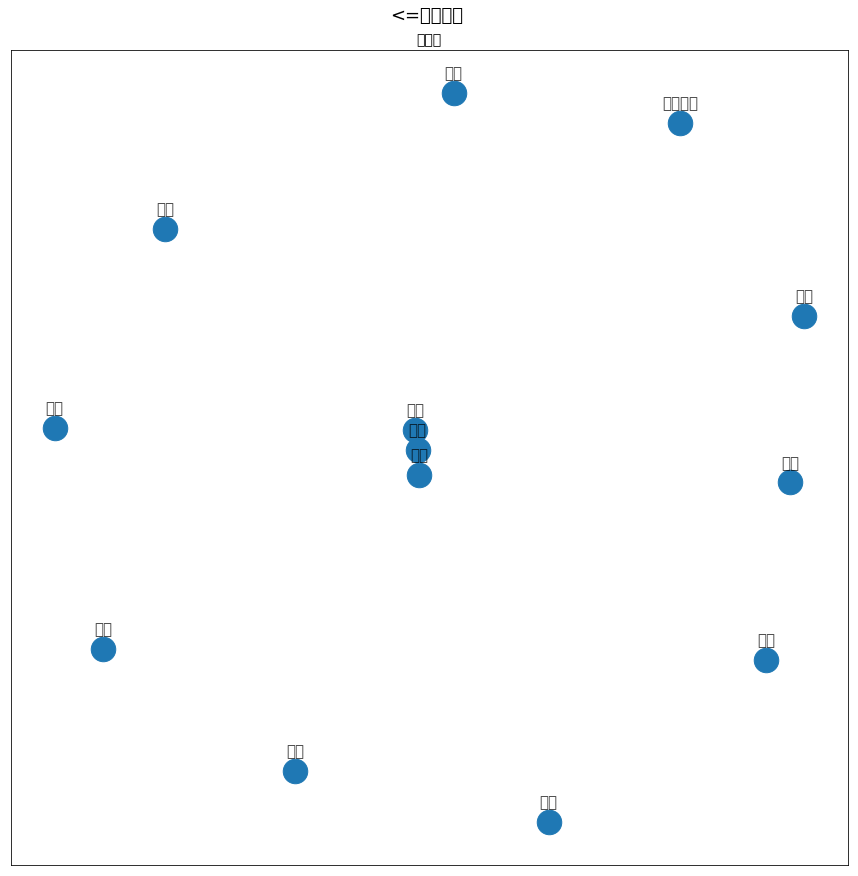

In [44]:
import networkx as nx
plt.figure(figsize=(15,15))
plt.rcParams['font.sans-serif'] = ['SimHei']   
g = nx.Graph()

for i in range(0,LessTDM.columns.size):
    for j in range(0,LessTDM.columns.size):
        if (LessdataFrame[LessdataFrame.index[i]][LessdataFrame.index[j]] > 2):
            g.add_edge(LessdataFrame.index[i], LessdataFrame.index[j], weight=LessdataFrame[LessdataFrame.index[i]][LessdataFrame.index[j]])
            
pos = nx.spring_layout(g)
# nodes
nx.draw_networkx_nodes(g, pos, node_size=600)
# edges
nx.draw_networkx_edges(g, pos, node_color='b', alpha=0.2)
# labels
for p in pos:  # raise text positions
    pos[p][1] = pos[p][1] + 0.05
nx.draw_networkx_labels(g, pos, font_size = 15, font_family='sans-serif', alpha=0.8)


plt.title('共線圖', size = 14)
plt.suptitle('<=兩次通話',x = 0.51,y=0.92, fontsize=18)
plt.savefig("用詞共現圖_<=兩次通話.png", dpi=100)
plt.show()

In [24]:
MoreTDM = None
for client in MoreClienteachPhoneCall:
    AllCall = ",".join(MoreClienteachPhoneCall[client])
    WordDict = MakeWordDictIn1Row(AllCall)
    tmp_tdm = pd.DataFrame(data=WordDict, index=[0])
    MoreTDM = pd.concat([MoreTDM, tmp_tdm], ignore_index=True)

MoreTDM = MoreTDM.fillna(0)
clientsID = list(MoreClienteachPhoneCall.keys())
indexList = list(MoreTDM.index.values)
d = {}
for idx in range(len(indexList)):
    d[indexList[idx]]=clientsID[idx]
MoreTDM.rename(index=d, inplace=True)
MoreTDM.head()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,中信,中債會,中國,中巴,中東,中機會,中華,中銀,亞高,俄,...,試試,談,豐銀,豐銀行,貿易,通訊,運用,銷售,非,預算
AA3678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AA3363,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AA2841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AA7780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AA3313,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# Co-occurrence Matrix
MoreTDMarray = MoreTDM.values

MoreMatrix = np.dot(MoreTDMarray.T, MoreTDMarray)

column_name = MoreTDM.columns.values
MoredataFrame = pd.DataFrame(data=MoreMatrix,columns=column_name,index=column_name)
MoredataFrame

,中信,中債會,中國,中巴,中東,中機會,中華,中銀,亞高,俄,...,試試,談,豐銀,豐銀行,貿易,通訊,運用,銷售,非,預算
中信,23.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
中債會,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
中國,7.0,0.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,7.0,0.0,0.0,0.0,0.0,5.0,0.0,2.0,0.0,2.0
中巴,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
中東,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
中機會,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
中華,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
中銀,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
亞高,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
俄,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


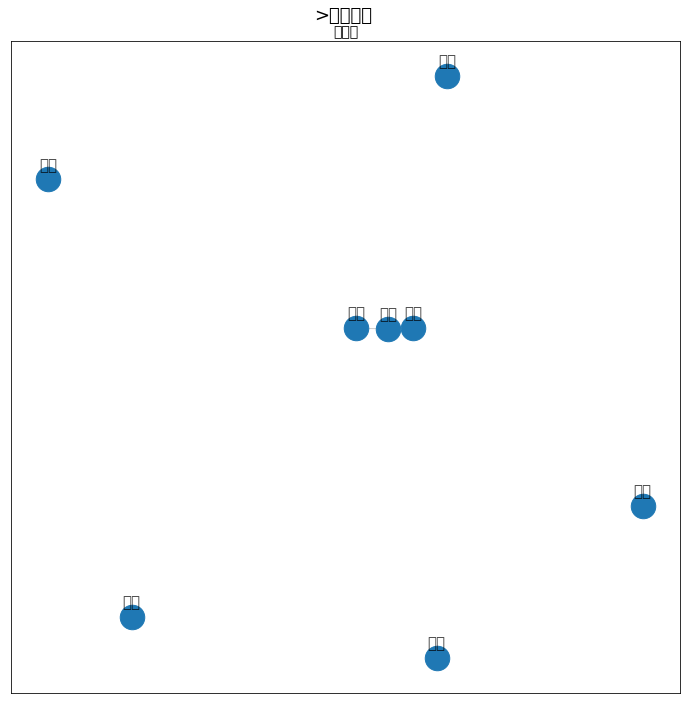

In [52]:
from matplotlib.font_manager import FontProperties
font=FontProperties(fname='./SimHei.ttf', size=10)
plt.rcParams['font.family']=['SimHei']
plt.figure(figsize=(12,12))
#plt.rcParams['font.sans-serif'] = ['SimHei']   
g = nx.Graph()

for i in range(0,MoreTDM.columns.size):
    for j in range(0,MoreTDM.columns.size):
        if (MoredataFrame[MoredataFrame.index[i]][MoredataFrame.index[j]] > 7):
            g.add_edge(MoredataFrame.index[i], MoredataFrame.index[j], weight=MoredataFrame[MoredataFrame.index[i]][MoredataFrame.index[j]])
            
pos = nx.spring_layout(g)
# nodes
nx.draw_networkx_nodes(g, pos, node_size=600)
# edges
nx.draw_networkx_edges(g, pos, node_color='b', alpha=0.2)
# labels
for p in pos:  # raise text positions
    pos[p][1] = pos[p][1] + 0.05
#nx.draw_networkx_labels(g, pos, fontproperties=font, alpha=0.8)

nx.draw_networkx_labels(g, pos, font_size = 15, font_family='sans-serif', alpha=0.8)


plt.title('共線圖', size = 14)
plt.suptitle('>兩次通話',x = 0.51,y=0.92, fontsize=18)
plt.savefig("用詞共現圖_>兩次通話.png", dpi=100)
plt.show()

In [10]:
# 以時間去看
import datetime
min_time = datetime.datetime(2018, 1, 1, 1, 0)
max_time = datetime.datetime(2018, 12, 31, 23, 59)

time_block = [datetime.datetime(2018, month, 1, 1, 1) for month in range(1, 13)]
time_block.append(datetime.datetime(2019, 1, 1, 1, 1))
time_block

[datetime.datetime(2018, 1, 1, 1, 1),
 datetime.datetime(2018, 2, 1, 1, 1),
 datetime.datetime(2018, 3, 1, 1, 1),
 datetime.datetime(2018, 4, 1, 1, 1),
 datetime.datetime(2018, 5, 1, 1, 1),
 datetime.datetime(2018, 6, 1, 1, 1),
 datetime.datetime(2018, 7, 1, 1, 1),
 datetime.datetime(2018, 8, 1, 1, 1),
 datetime.datetime(2018, 9, 1, 1, 1),
 datetime.datetime(2018, 10, 1, 1, 1),
 datetime.datetime(2018, 11, 1, 1, 1),
 datetime.datetime(2018, 12, 1, 1, 1),
 datetime.datetime(2019, 1, 1, 1, 1)]

In [11]:
CallOutListByTime = {}    #dict key:時間區段，value:客戶人數
CallOutContentByTime = {} #dict key：時間區段，value：通話內容
for row in clean_data:
    for idx in range(1, len(time_block)):
        if  time_block[idx-1] <= datetime.datetime.strptime(row[2], "%Y%m%d %H%M%S") < time_block[idx]:
            if time_block[idx-1] not in CallOutListByTime:
                CallOutListByTime[time_block[idx-1]] = 0
                CallOutContentByTime[time_block[idx-1]] = []
            CallOutListByTime[time_block[idx-1]] += 1
            CallOutContentByTime[time_block[idx-1]].append(row[3])
            

<BarContainer object of 12 artists>

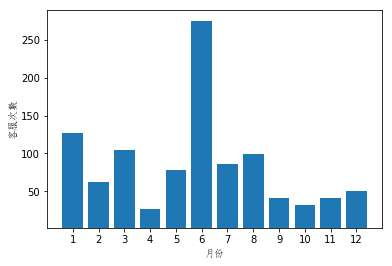

In [12]:
keys=["{}".format(key.month) for key in CallOutListByTime.keys()]
values=list(CallOutListByTime.values())

fig = plt.figure()
plt.xlabel('月份', fontproperties=zhfont1)
plt.ylabel('客服次數', fontproperties=zhfont1)
plt.bar(keys, height=values, bottom=2.0)


從圖中可以看出六月的客服次數非常高，所以我們分析看看六月到底都推銷了些什麼？
是因為推銷的產品呢，又或是因為是單一客戶的偏好呢(可能有些客戶就是習慣在六月買產品)？

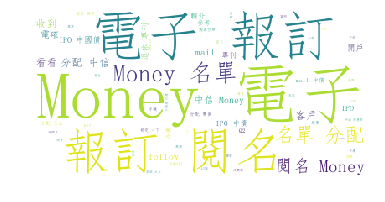

<Figure size 1000x1000 with 0 Axes>

In [13]:
MakeWordCloud(CallOutContentByTime[datetime.datetime(2018,6,1,1,1)])

In [17]:
UniqueClient=[]
ClientCall = {} # dict key:客戶ＩＤ，value:[通話次數，[每通的通話內容]]
for row in clean_data:
    if datetime.datetime(2018,6,1,1,1) < datetime.datetime.strptime(row[2], "%Y%m%d %H%M%S") < datetime.datetime(2018,7,1,1,1):
        if row[1] not in UniqueClient:
            UniqueClient.append(row[1])
            ClientCall[row[1]] = [0, []]
        ClientCall[row[1]][0] += 1
        ClientCall[row[1]][1].append(row[3])

        
        
len(UniqueClient)


211

光是6月的Unique client有211位，我們分析各個月份的Unique ID來看究竟是六月真的是觸及客戶較多還是有別的原因。

<BarContainer object of 12 artists>

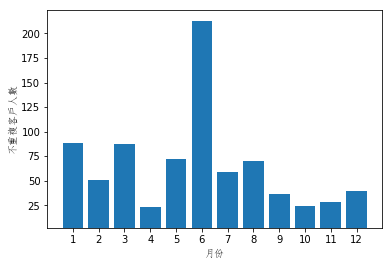

In [18]:
UniqueClientInYear={}
for row in clean_data:
    for idx in range(1, len(time_block)):
        if  time_block[idx-1] <= datetime.datetime.strptime(row[2], "%Y%m%d %H%M%S") < time_block[idx]:
            if time_block[idx-1] not in UniqueClientInYear:
                UniqueClientInYear[time_block[idx-1]] = []
            if row[1] not in UniqueClientInYear[time_block[idx-1]]:
                UniqueClientInYear[time_block[idx-1]].append(row[1])
            
keys=["{}".format(key.month) for key in UniqueClientInYear.keys()]
values=[len(UniqueClientInYear[key]) for key in UniqueClientInYear.keys()]

fig = plt.figure()
plt.xlabel('月份', fontproperties=zhfont1)
plt.ylabel('不重複客戶人數', fontproperties=zhfont1)
plt.bar(keys, height=values, bottom=2.0)

OK，趨勢大致相同，所以可以看出的確是6月的銷售特別好

<BarContainer object of 5 artists>

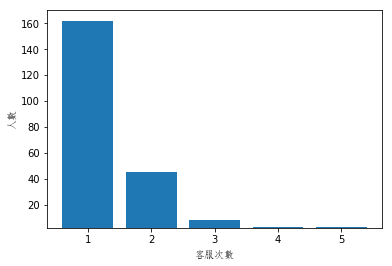

In [19]:
ClientCallTimes = [call[0] for call in ClientCall.values()]
CallOutNum = {}
for term in ClientCallTimes:
    if term not in CallOutNum:
        CallOutNum[term] = 0
    CallOutNum[term] += 1
    
keys = list(CallOutNum.keys())
values = list(CallOutNum.values())

fig = plt.figure()
plt.xlabel('客服次數', fontproperties=zhfont1)
plt.ylabel('人數', fontproperties=zhfont1)
plt.bar(keys, height=values, bottom=2.0)

多數的客戶都只打了一通，但也有40,50個客戶是打了超過兩通，我們來研究看看

In [20]:
#分析 在六月打了兩通以上的客戶，到底講了什麼
content = []
for client in ClientCall:
    if ClientCall[client][0] >= 2:
        for row in ClientCall[client][1]:
            content.append(row)
            
content[:5]

['[ECP]沒信心 沒錢 IPO',
 '"[ECP]帳號過長需修正',
 '"[ECP]電確',
 '[ECP]本來想要賣4年期 有資需求',
 'Money名單分配  款台外 轉介559']

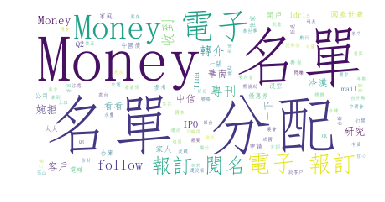

<Figure size 1000x1000 with 0 Axes>

In [21]:
MakeWordCloud(content)

”名單“在六月的打超過兩通以上的客戶客服紀錄頻繁出現